Форма данных: (1715, 266)

Признаки с пропущенными значениями (до обработки):
ENROLL                   491
TOTAL_REVENUE            440
FEDERAL_REVENUE          440
STATE_REVENUE            440
LOCAL_REVENUE            440
                        ... 
G08_AM_A_MATHEMATICS    1655
G08_HP_A_READING        1701
G08_HP_A_MATHEMATICS    1702
G08_TR_A_READING        1574
G08_TR_A_MATHEMATICS    1570
Length: 263, dtype: int64

Признаки с пропущенными значениями (после обработки):
Все пропуски устранены.

Распределение классов:
Revenue_Class
2    170
1    165
0    165
Name: count, dtype: int64

Метрики для Логистическая регрессия:
Accuracy:  0.9400
Precision: 0.9451
Recall:    0.9400
F1-score:  0.9408

Отчет классификации:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95        33
           1       0.86      0.97      0.91        33
           2       1.00      0.91      0.95        34

    accuracy                           0.94       100
  

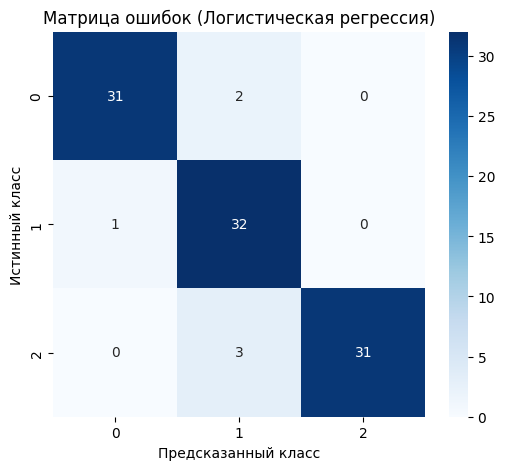


Метрики для Случайный лес:
Accuracy:  0.9700
Precision: 0.9709
Recall:    0.9700
F1-score:  0.9700

Отчет классификации:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.94      0.97      0.96        33
           2       1.00      0.94      0.97        34

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



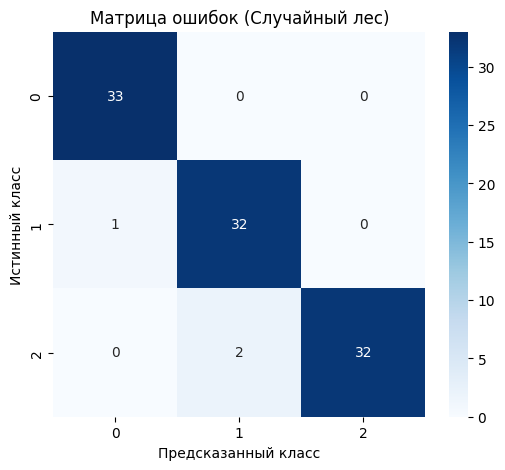

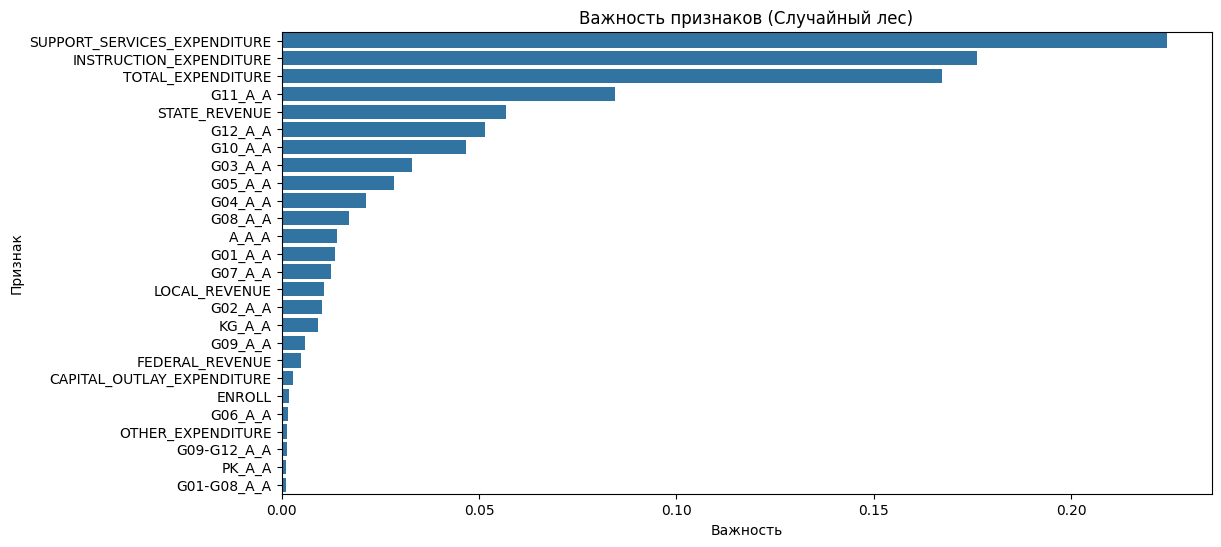

In [9]:
!pip install pandas scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Загрузка данных
df = pd.read_csv('/content/states_all_extended.csv')

print("Форма данных:", df.shape)

# Предварительный анализ пропусков
missing_before = df.isnull().sum()
missing_before = missing_before[missing_before > 0]
print("\nПризнаки с пропущенными значениями (до обработки):")
print(missing_before)

# Удаляем неинформативные признаки
df = df.drop(columns=['STATE', 'PRIMARY_KEY', 'YEAR'], errors='ignore')

# Оставляем признаки с пропусками менее 50%
df = df.loc[:, df.isnull().mean() < 0.5]

# Заполняем пропуски средними значениями (числовые признаки)
df.fillna(df.mean(numeric_only=True), inplace=True)

print("\nПризнаки с пропущенными значениями (после обработки):")
missing_after = df.isnull().sum()
missing_after = missing_after[missing_after > 0]
print(missing_after if not missing_after.empty else "Все пропуски устранены.")

# Оставляем только числовые признаки (логистическая регрессия требует числовых)
df = df.select_dtypes(include=[np.number])

# Удаляем признаки с одной уникальной величиной
const_features = [col for col in df.columns if df[col].nunique() <= 1]
if const_features:
    df = df.drop(columns=const_features)

# Ограничимся первыми 500 строками для ускорения
df = df.head(500)

target = 'TOTAL_REVENUE'
df = df.dropna(subset=[target])  # Удаляем строки с пропуском в целевой переменной

# Классификация: делим TOTAL_REVENUE на 3 класса по квантилям
quantiles = df[target].quantile([0.33, 0.66]).values
def revenue_to_class(x):
    if x <= quantiles[0]:
        return 0  # Низкий доход
    elif x <= quantiles[1]:
        return 1  # Средний доход
    else:
        return 2  # Высокий доход

df['Revenue_Class'] = df[target].apply(revenue_to_class)

print("\nРаспределение классов:")
print(df['Revenue_Class'].value_counts())

# Формируем признаки и целевую переменную для классификации
X = df.drop(columns=[target, 'Revenue_Class'])
y = df['Revenue_Class']

# Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Делим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Обучение логистической регрессии
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# Обучение случайного леса
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Функция для оценки моделей
def evaluate_classification(y_true, y_pred, model_name):
    print(f"\nМетрики для {model_name}:")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred, average='weighted'):.4f}")
    print("\nОтчет классификации:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Матрица ошибок ({model_name})")
    plt.xlabel("Предсказанный класс")
    plt.ylabel("Истинный класс")
    plt.show()

# Оценка обеих моделей
evaluate_classification(y_test, y_pred_logreg, "Логистическая регрессия")
evaluate_classification(y_test, y_pred_rf, "Случайный лес")

# Важность признаков для случайного леса
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Важность признаков (Случайный лес)")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.show()
